https://www.tensorflow.org/tutorials/images/classification


In [ ]:
import os
import PIL
import cv2
import glob
import pathlib
import zipfile
import numpy as np
from fastai import *
from PIL import Image
import tensorflow as tf
from fastai.vision import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import *
from tensorflow.keras.models import Sequential
from fastai.metrics import error_rate, accuracy
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/Team 15 Emotion Recognition/EmotionRecognition/dataset/data.zip" -d "/content/drive/My Drive/Team 15 Emotion Recognition/EmotionRecognition/dataset"

In [ ]:
#Set up paths for train and test data
data_dir = '/content/drive/MyDrive/Team 15 Emotion Recognition/EmotionRecognition/dataset/data/' #if you need to put your own path, comment this line out and add yours (DONT DELETE)
train_path = data_dir + 'train/'
test_path = data_dir + 'test/'

## Setting Up Our Data
Let's sort and initialize our dataset into some variables.

In [ ]:
def mylistdir(directory):
    """A specialized version of os.listdir() that ignores files that
    start with a leading period."""
    filelist = os.listdir(directory)
    return [x for x in filelist
            if not (x.startswith('.'))]

#Display class labels
labels= mylistdir(train_path)
labels

['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

In [ ]:
file_count = len(list(pathlib.Path(data_dir).glob('*/*/*.png')))
print('Total image count:', file_count)

file_count = len(list(pathlib.Path(train_path).glob('*/*.png')))
print('Total training images:', file_count)

file_count = len(list(pathlib.Path(test_path).glob('*/*.png')))
print('Total testing images:', file_count)

Total image count: 33349
Total training images: 26171
Total testing images: 7178


## Labels in our Dataset
Using matplotlib, we can visualize an example of each label in our dataset.

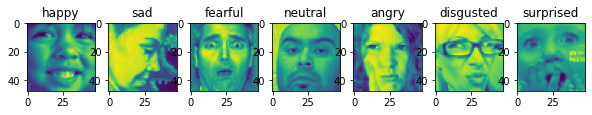

In [ ]:
#Display our 7 emotion labels and example image from each class
fig, axes = plt.subplots(1, 7, figsize=(10,10))

for i in range(7):

    ex_image = train_path + labels[i]+ '/' + mylistdir(train_path + labels[i]+'/')[0]
    axes[i].imshow(plt.imread(ex_image))
    axes[i].set_title(labels[i])

plt.show()

We can also visualize a distribution of our labels across all of our images.

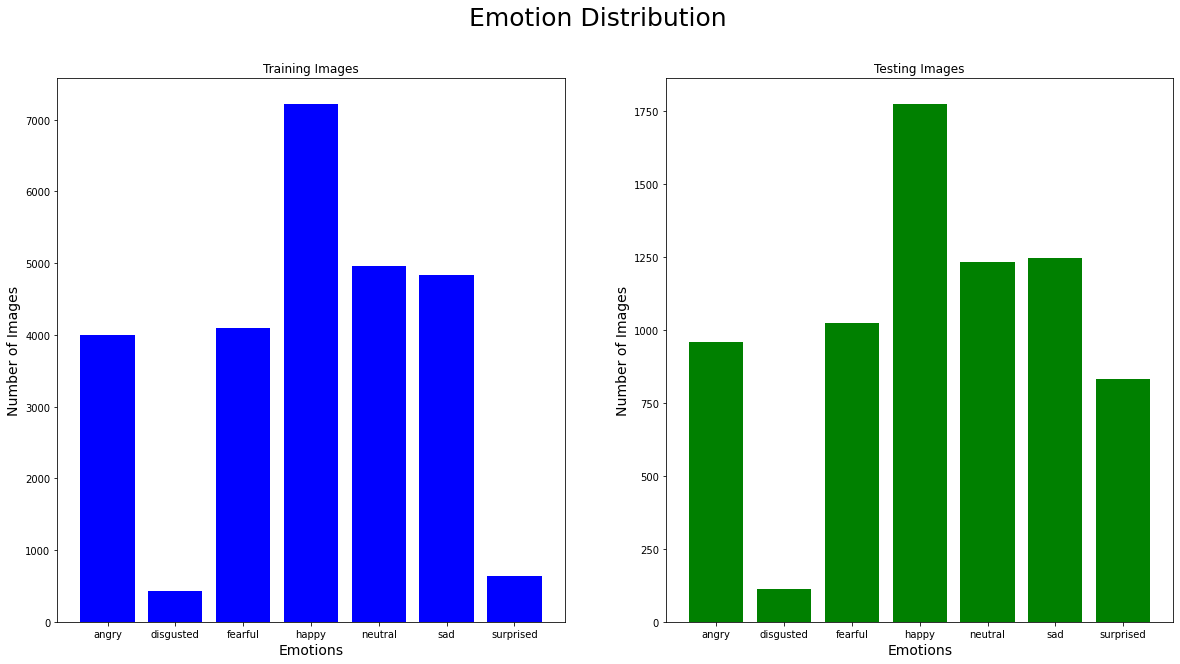

In [106]:
surprised_train = sum(len(files) for _, _, files in os.walk(train_path + 'surprised' + '/'))
disgusted_train = sum(len(files) for _, _, files in os.walk(train_path + 'disgusted' + '/'))
angry_train = sum(len(files) for _, _, files in os.walk(train_path + 'angry' + '/'))
neutral_train = sum(len(files) for _, _, files in os.walk(train_path + 'neutral' + '/'))
fearful_train = sum(len(files) for _, _, files in os.walk(train_path + 'fearful' + '/'))
sad_train = sum(len(files) for _, _, files in os.walk(train_path + 'sad' + '/'))
happy_train = sum(len(files) for _, _, files in os.walk(train_path + 'happy' + '/'))

surprised_test = sum(len(files) for _, _, files in os.walk(test_path + 'surprised' + '/'))
disgusted_test = sum(len(files) for _, _, files in os.walk(test_path + 'disgusted' + '/'))
angry_test = sum(len(files) for _, _, files in os.walk(test_path + 'angry' + '/'))
neutral_test = sum(len(files) for _, _, files in os.walk(test_path + 'neutral' + '/'))
fearful_test = sum(len(files) for _, _, files in os.walk(test_path + 'fearful' + '/'))
sad_test = sum(len(files) for _, _, files in os.walk(test_path + 'sad' + '/'))
happy_test = sum(len(files) for _, _, files in os.walk(test_path + 'happy' + '/'))

#'angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'
train_dist = np.array([angry_train, disgusted_train, fearful_train, happy_train, neutral_train, sad_train, surprised_train])
test_dist = np.array([angry_test, disgusted_test, fearful_test, happy_test, neutral_test, sad_test, surprised_test])
x = np.array(labels)

plt.figure(figsize=(20,10))
plt.suptitle('Emotion Distribution', fontsize=25)

ax1 = plt.subplot(1,2,1)
ax1.set_title('Training Images')
plt.xlabel('Emotions', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.bar(x, train_dist, color='blue')
#plt.show()

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('Testing Images')
plt.xlabel('Emotions', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.bar(x, test_dist, color='green')
plt.show()

## Data Preprocessing
Now that we have a feel for our image data, we can preprocess our images using fastai's ImageDataBunch to formally define our dataset that our model will be trained on.

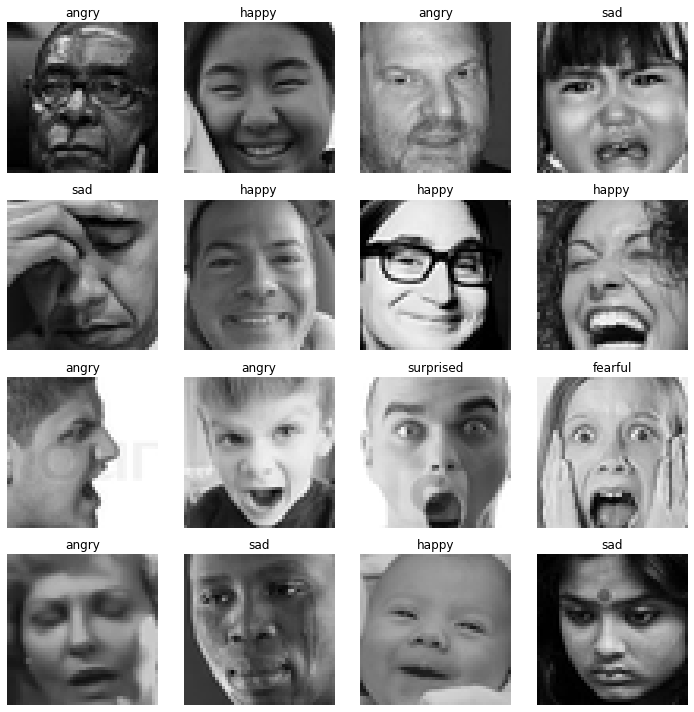

In [ ]:
import warnings
warnings.filterwarnings('ignore')

'''
Referenced from FastAI's documentation: https://fastai1.fast.ai/vision.data.html#ImageDataBunch
'''

data = ImageDataBunch.from_folder(data_dir, train='train', valid='test', size=48, bs=16)

data.show_batch(figsize=(10,10))

In [ ]:
print(data.classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (26171 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: /content/drive/MyDrive/Team 15 Emotion Recognition/EmotionRecognition/dataset/data;

Valid: LabelList (7178 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: /content/drive/MyDrive/Team 15 Emotion Recognition/EmotionRecognition/dataset/data;

Test: None

In [ ]:
#specify train,test data and create validation set
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
					train_path,
          subset='training',
					color_mode = 'grayscale',
					target_size = (48, 48),
					batch_size = 64,
					class_mode = 'categorical')

valid = train_datagen.flow_from_directory(
							train_path,
              subset='validation',
							color_mode = 'grayscale',
							target_size = (48, 48),
							batch_size = 64,
							class_mode = 'categorical')

test = test_datagen.flow_from_directory(
							test_path,
							color_mode = 'grayscale',
							target_size = (48, 48),
							batch_size = 64,
							class_mode = 'categorical')

Found 20938 images belonging to 7 classes.
Found 5233 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Create CNN Model
Motivation for using CNN: 
- We used CNN (Convolutional Neural Network) for our image classification because of its high accuracy, hierarchical model, and ability to automatically detect important features. It is also computationally effective because all of the layers are fully connected.

In [ ]:
model = tf.keras.Sequential()
def build_model(size):
    model.add(Conv2D(size,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(size,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

build_model(32)
build_model(64)
#build_model(128)

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
run = model.fit(train, 
                 validation_data=valid,
                 epochs=3)

Epoch 1/3
328/328 [==============================] - 5739s 17s/step - loss: 1.8783 - accuracy: 0.2599 - val_loss: 1.6803 - val_accuracy: 0.3117
Epoch 2/3
328/328 [==============================] - 60s 184ms/step - loss: 1.5416 - accuracy: 0.3847 - val_loss: 1.4238 - val_accuracy: 0.4431
Epoch 3/3
328/328 [==============================] - 59s 179ms/step - loss: 1.3951 - accuracy: 0.4526 - val_loss: 1.3027 - val_accuracy: 0.4925


In [ ]:
run = model.fit(train, 
                 validation_data=valid,
                 epochs=30)

Epoch 1/30
328/328 [==============================] - 59s 179ms/step - loss: 1.3337 - accuracy: 0.4802 - val_loss: 1.4229 - val_accuracy: 0.4256
Epoch 2/30
328/328 [==============================] - 57s 175ms/step - loss: 1.2690 - accuracy: 0.5127 - val_loss: 1.2471 - val_accuracy: 0.5198
Epoch 3/30
328/328 [==============================] - 58s 177ms/step - loss: 1.2250 - accuracy: 0.5288 - val_loss: 1.1713 - val_accuracy: 0.5446
Epoch 4/30
328/328 [==============================] - 57s 173ms/step - loss: 1.1732 - accuracy: 0.5549 - val_loss: 1.2036 - val_accuracy: 0.5345
Epoch 5/30
328/328 [==============================] - 57s 172ms/step - loss: 1.1988 - accuracy: 0.5469 - val_loss: 1.2985 - val_accuracy: 0.4928
Epoch 6/30
328/328 [==============================] - 58s 177ms/step - loss: 1.1502 - accuracy: 0.5641 - val_loss: 1.1909 - val_accuracy: 0.5551
Epoch 7/30
328/328 [==============================] - 60s 183ms/step - loss: 1.0875 - accuracy: 0.5909 - val_loss: 1.1225 - val_ac

## Evaluating Results
Let's visualize our error/loss values and metrics

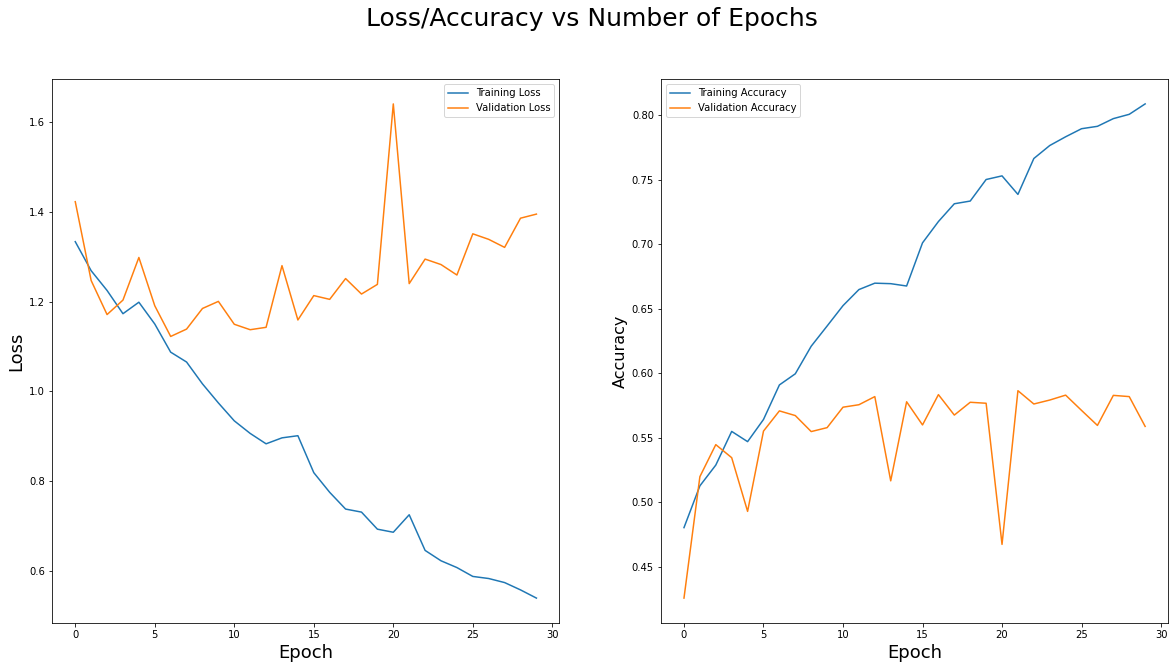

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle('Loss/Accuracy vs Number of Epochs', fontsize=25)

plt.subplot(1, 2, 1)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(run.history['loss'], label='Training Loss')
plt.plot(run.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(run.history['accuracy'], label='Training Accuracy')
plt.plot(run.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

## Testing out the Model
Lets preload a random image from our test dataset and see if our model can accurately predict its emotion.


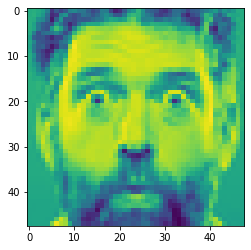

In [116]:
img = image.load_img(test_path+"/surprised/im30.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

In [117]:
labels = data.classes #grab the 7 emotion labels
img = np.expand_dims(img,axis = 0) #reshapes to 1,48,48
img = img.reshape(1,48,48,1)
result = model.predict(img) #using model to predict emotion of image
result = list(result[0])

#print result - we see that the image slightly detected the fearful emotion as well as surprised
print(result)
labels

[0.0, 0.0, 3.727637e-12, 0.0, 0.0, 0.0, 1.0]


['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [124]:
img_index = result.index(max(result))
print('Prediction:',labels[img_index])

Prediction: surprised


## Final Thoughts
Predictions seem to be accurate except for cases of images that show the emotion of disgust. Disgust tends to get confused with happiness and anger. We can work on improving this by increasing the number of "disgusted" images in our dataset, and tweaking our hyperparameters in our model.